In [1]:
%matplotlib inline

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame, impute, roll_time_series
from sklearn.ensemble import AdaBoostRegressor

## 创建信号

In [8]:
# [start, stop) = np.arange([start,] stop[, step,], dtype=None)
# [start, stop] = np.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
# arange根据步长，linspace根据点的个数，endpoint=True时包含最后一个点

# numpy.random.normal(loc=0.0, scale=1.0, size=None)
# 均值，标准差，输出值的个数

# np.concatenate((a1, a2, ...), axis=0, out=None)
# 在某一维度上拼接矩阵

x_up = np.arange(100)*0.1 + np.sin(30*np.pi*np.linspace(0, 1, 100))
+ np.random.normal(scale=0.7, size=100)

x_down = np.arange(100, 0, -1)*0.15 + np.sin(30*np.pi*np.linspace(0, 1, 100))
+ np.random.normal(scale=0.7, size=100)

x = np.concatenate([x_up, x_down])
# 生成相应的时间戳后生成时间序列
x = pd.Series(data=x, index=pd.date_range('1/1/2011', periods=len(x), freq='H'))
x.head()

2011-01-01 00:00:00    0.000000
2011-01-01 01:00:00    0.914576
2011-01-01 02:00:00    1.145001
2011-01-01 03:00:00    0.581733
2011-01-01 04:00:00   -0.218159
Freq: H, dtype: float64

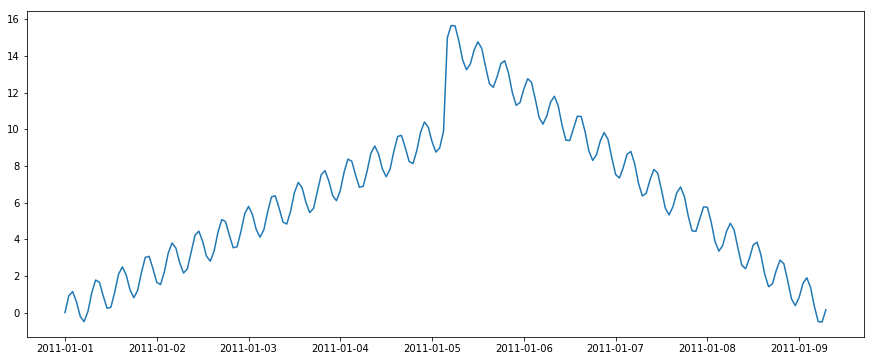

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(x)
plt.show()

##### 构建feature maxtrix

In [10]:
df = pd.DataFrame(x)
# DataFrame.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
# drop=True删除原索引生成新的索引：拼接后的数据索引不会改变；inplace=True,在原对象上修改，不生成新对象
df.reset_index(inplace=True)
df.columns = ["time", "value"]
df["kind"] = "a"
df["id"] = 1

In [11]:
df.head()

,time,value,kind,id
0,2011-01-01 00:00:00,0.000000,a,1
1,2011-01-01 01:00:00,0.914576,a,1
2,2011-01-01 02:00:00,1.145001,a,1
3,2011-01-01 03:00:00,0.581733,a,1
4,2011-01-01 04:00:00,-0.218159,a,1


In [12]:
len(df)

200

In [13]:
df_shift, y = make_forecasting_frame(x, kind="price", max_timeshift=10, rolling_direction=1)

In [25]:
df_shift.head(10)

,time,value,id,kind
1746,2011-01-01 00:00:00,0.000000,2011-01-01 01:00:00,price
1548,2011-01-01 00:00:00,0.000000,2011-01-01 02:00:00,price
1747,2011-01-01 01:00:00,0.914576,2011-01-01 02:00:00,price
1351,2011-01-01 00:00:00,0.000000,2011-01-01 03:00:00,price
1549,2011-01-01 01:00:00,0.914576,2011-01-01 03:00:00,price
1748,2011-01-01 02:00:00,1.145001,2011-01-01 03:00:00,price
1155,2011-01-01 00:00:00,0.000000,2011-01-01 04:00:00,price
1352,2011-01-01 01:00:00,0.914576,2011-01-01 04:00:00,price
1550,2011-01-01 02:00:00,1.145001,2011-01-01 04:00:00,price
1749,2011-01-01 03:00:00,0.581733,2011-01-01 04:00:00,price


##### 可以观察到，df_shift是df的偏移序列，其中max_timeshift=10表示最大取10个点，rolling_direction=1表示取点从小到大，步伐=1

##### 将df_shift作为目标序列来提取特征，表示每个点的特征都取前10个数据点的计算结果

In [20]:
len(df_shift)

1945

In [16]:
# 会自动根据时间戳来计算df_shift的特征？？？
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value",
                    impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.73it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_tre

In [17]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-1,value__value_count__value_0,value__value_count__value_1,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0
2011-01-01 02:00:00,0.836449,0.914576,-1.000000,-1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.209112,0.0
2011-01-01 03:00:00,2.147476,1.145001,-0.696825,-0.696825,0.348660,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.199034,0.000000,0.0,0.0,1.0,0.0,0.244508,0.0
2011-01-01 04:00:00,2.485889,1.708269,-0.261897,-0.148750,0.245072,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.314391,0.000000,0.0,0.0,1.0,0.0,0.185440,0.0
2011-01-01 05:00:00,2.533482,2.508161,-0.058511,-0.288323,0.700475,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,-0.035400,0.054494,0.0,0.0,1.0,0.0,0.271830,0.0


In [21]:
len(X)

199

## 预测

In [32]:
ada = AdaBoostRegressor()

y_pred = [0] * len(y)
y_pred[0] = y.iloc[0]

for i in range(1, len(y)):
    # 与上述df_shift相对应
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))
    
y_pred = pd.Series(data=y_pred, index=y.index)

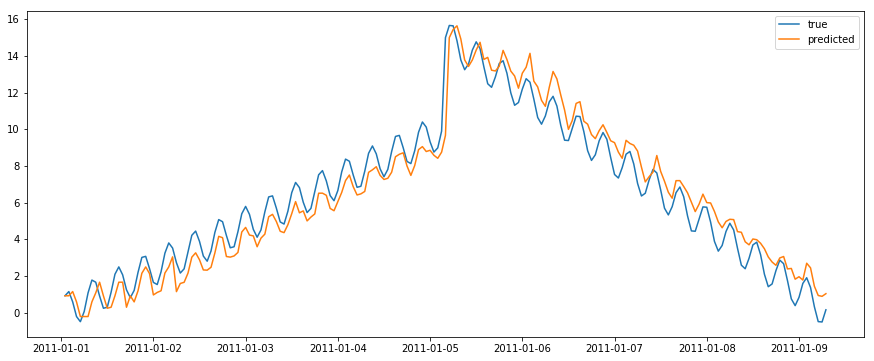

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()